Setup — install and imports

In [12]:
# Run this first in Colab or Jupyter
!pip install -q nltk scikit-learn matplotlib seaborn

import nltk
nltk.download('movie_reviews')   # movie_reviews dataset
nltk.download('punkt')
nltk.download('punkt_tab')  # Additional resource needed for tokenization
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import movie_reviews, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import random
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\kalith\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kalith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kalith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kalith\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kalith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2.Load dataset and create DataFrame

In [13]:
# Prepare dataset (movie_reviews from nltk)
docs = []
labels = []

for fileid in movie_reviews.fileids():
    category = movie_reviews.categories(fileid)[0]  # 'pos' or 'neg'
    text = movie_reviews.raw(fileid)
    docs.append(text)
    labels.append(category)

df = pd.DataFrame({'text': docs, 'label': labels})
df['label'] = df['label'].map({'pos': 1, 'neg': 0})  # 1 = positive, 0 = negative

# Shuffle for safety
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()


,text,label
0,the verdict : spine-chilling drama from horror...,1
1,""" the 44 caliber killer has struck again . "" ...",0
2,in the company of men made a splash at the sun...,1
3,"in the year 2029 , captain leo davidson ( mark...",0
4,[note that followups are directed to rec . art...,1


3. Preprocessing function (cleaning, tokenization, lemmatization)

In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Keep alphabetic tokens, remove stopwords and short tokens
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words and len(t) > 2]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

# Apply preprocessing (this may take a few seconds)
df['clean_text'] = df['text'].apply(preprocess)
df[['clean_text']].head()


,clean_text
0,verdict drama horror maestro stephen king feat...
1,caliber killer struck starring john leguizamo ...
2,company men made splash sundance film festival...
3,year captain leo davidson mark wahlberg boogie...
4,note followup directed rec art movie rec art m...


4. Train-test split

In [15]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train size:", len(X_train), "Test size:", len(X_test))


Train size: 1600 Test size: 400


5. Feature extraction — TF-IDF (and option to switch to BoW)

In [16]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Quick sanity
print("TF-IDF shape (train):", X_train_tfidf.shape)


TF-IDF shape (train): (1600, 32801)


6. Train models (Logistic Regression, Naive Bayes, SVM) and compare

In [17]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "MultinomialNB": MultinomialNB(),
    "LinearSVC": LinearSVC(max_iter=5000)
}

trained = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    trained[name] = model
    preds = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, preds)
    print(f"{name} accuracy: {acc:.4f}")


LogisticRegression accuracy: 0.8325
MultinomialNB accuracy: 0.8350
LinearSVC accuracy: 0.8600


7. Evaluate best model in detail (choose one; e.g., Logistic Regression)

Classification report:

              precision    recall  f1-score   support

    negative       0.82      0.86      0.84       200
    positive       0.85      0.81      0.83       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



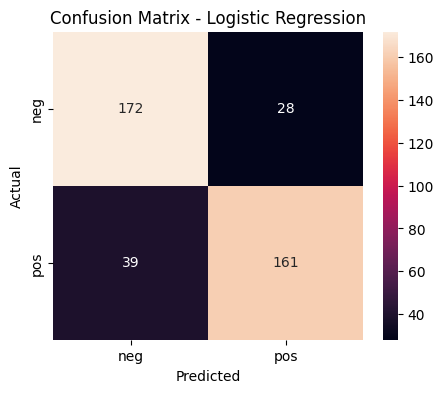

In [18]:
best_model = trained['LogisticRegression']
y_pred = best_model.predict(X_test_tfidf)

print("Classification report:\n")
print(classification_report(y_test, y_pred, target_names=['negative','positive']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['neg','pos'], yticklabels=['neg','pos'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


8. Show most informative features (words)

In [19]:
# Get top features for positive and negative weights (LogisticRegression)
feature_names = np.array(tfidf.get_feature_names_out())
coef = best_model.coef_[0]
top_pos_idx = np.argsort(coef)[-20:][::-1]
top_neg_idx = np.argsort(coef)[:20]

print("Top positive features:")
print(feature_names[top_pos_idx])

print("\nTop negative features:")
print(feature_names[top_neg_idx])


Top positive features:
['life' 'great' 'truman' 'world' 'also' 'war' 'well' 'performance'
 'family' 'excellent' 'many' 'best' 'quite' 'bulworth' 'see' 'love' 'true'
 'cameron' 'jackie' 'american']

Top negative features:
['bad' 'worst' 'plot' 'boring' 'stupid' 'nothing' 'supposed' 'movie'
 'look' 'harry' 'attempt' 'poor' 'waste' 'script' 'would' 'even' 'joke'
 'dull' 'unfortunately' 'could']


9. Real-time prediction demo (function to call in notebook)

In [20]:
def predict_sentiment(text, model=best_model, vectorizer=tfidf):
    text_proc = preprocess(text)
    vect = vectorizer.transform([text_proc])
    pred = model.predict(vect)[0]
    prob = None
    # LogisticRegression has predict_proba if available
    if hasattr(model, "predict_proba"):
        prob = model.predict_proba(vect)[0].max()
    label = "Positive" if pred == 1 else "Negative"
    return {"text": text, "processed": text_proc, "label": label, "confidence": prob}

# Example:
print(predict_sentiment("I absolutely loved this movie! Great acting and story."))
print(predict_sentiment("This was a boring waste of time. I hated it."))


{'text': 'I absolutely loved this movie! Great acting and story.', 'processed': 'absolutely loved movie great acting story', 'label': 'Positive', 'confidence': np.float64(0.5545868927326335)}
{'text': 'This was a boring waste of time. I hated it.', 'processed': 'boring waste time hated', 'label': 'Negative', 'confidence': np.float64(0.7813039458349167)}


10. (Optional) Save the model & vectorizer (for deployment)

In [21]:
import joblib
joblib.dump(best_model, "sentiment_lr_model.joblib")
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
print("Saved model and vectorizer.")


Saved model and vectorizer.
